In [47]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import os
import tqdm

Defining url for datasets


In [48]:
train_ds_url = "Teeth DataSet/Teeth_Dataset/Training"
test_ds_url = "Teeth DataSet/Teeth_Dataset/Testing"
val_ds_url = "Teeth DataSet/Teeth_Dataset/Validation"

In [49]:
def load_images_from_folder(folder_path):
    dataset = keras.preprocessing.image_dataset_from_directory(
        folder_path,
        label_mode='categorical',
        image_size=(224, 224),
        batch_size=32,
        shuffle=True,
        seed=42
    
    )
    return dataset

In [50]:
train_ds = load_images_from_folder(train_ds_url)    
test_ds = load_images_from_folder(test_ds_url)
val_ds = load_images_from_folder(val_ds_url)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [51]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


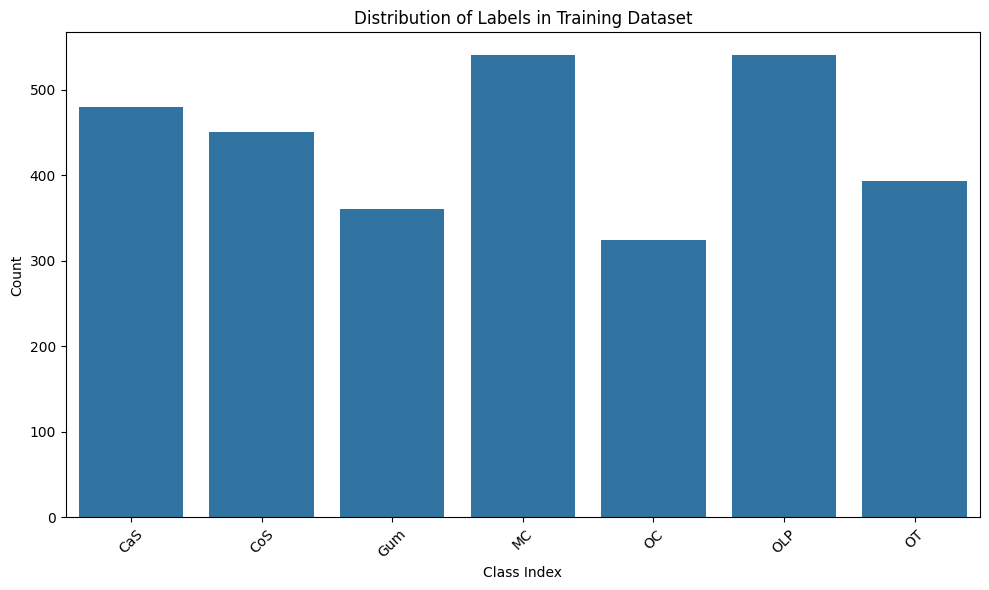

In [52]:
def get_all_labels(dataset):
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())
    return np.array(all_labels)

train_labels = get_all_labels(train_ds)

plt.figure(figsize=(10, 6))
sns.countplot(x=np.argmax(train_labels, axis=1))
plt.title('Distribution of Labels in Training Dataset')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()


Data is biased towards mc and olp and is minimum in oc and gum so we will add weights


In [53]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.arange(len(class_names)),
                                        y=np.argmax(train_labels, axis=1))
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


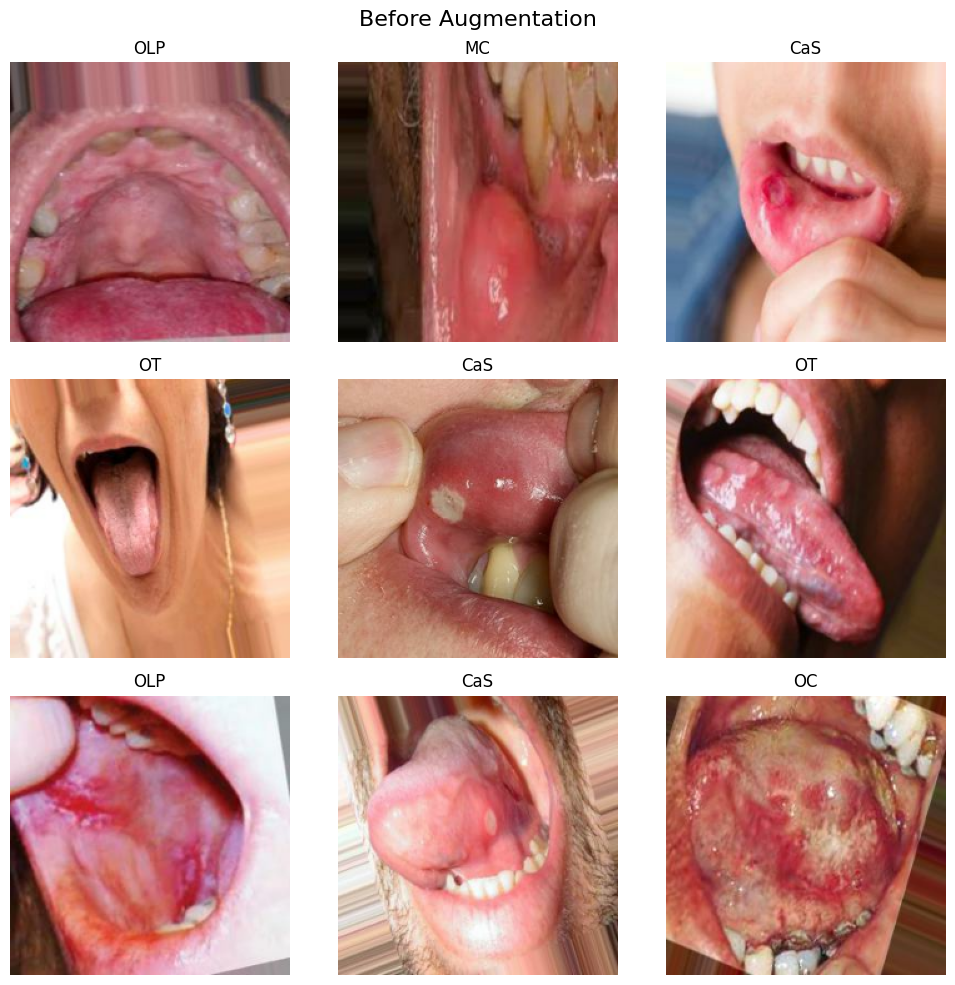

In [54]:
def show_batch(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = tf.argmax(labels[i]).numpy() if labels.shape[-1] > 1 else labels[i].numpy()
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle("Before Augmentation", fontsize=16)
    plt.tight_layout()
    plt.show()

show_batch(train_ds, class_names)


In [55]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
])


In [ ]:
normalization_layer = keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
def show_augmented_images(dataset, class_names):
    for images, labels in dataset:
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = tf.argmax(labels[i]).numpy() if labels.shape[-1] > 1 else labels[i].numpy()
            plt.title(class_names[label])
            plt.axis("off")
        plt.suptitle("After Augmentation", fontsize=16)
        plt.tight_layout()
        plt.show()
        break

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
show_augmented_images(augmented_train_ds, class_names)


AttributeError: '_MapDataset' object has no attribute 'class_names'

In [58]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3)),

    keras.layers.Conv2D(32, (3, 3), activation='relu'), 
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
model.summary()
    

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.fit(augmented_train_images,
          validation_data=val_ds,
          epochs=20,
          class_weight=class_weights,
          callbacks=[
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
          ])

Epoch 1/20


36/97 ━━━━━━━━━━━━━━━━━━━━ 37s 622ms/step - Precision: 0.1473 - Recall: 0.0930 - accuracy: 0.1504 - loss: 105.1457

KeyboardInterrupt: 